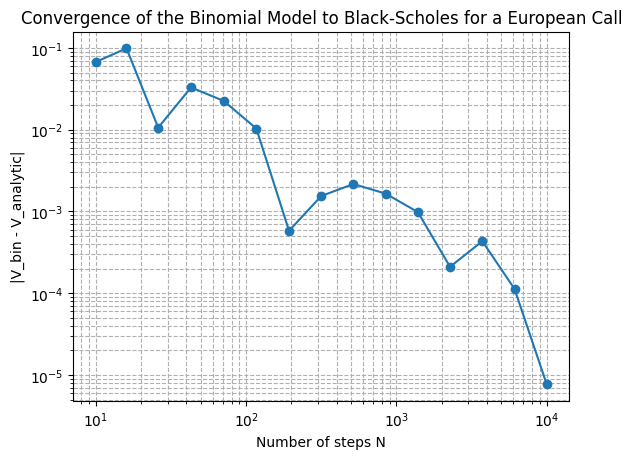

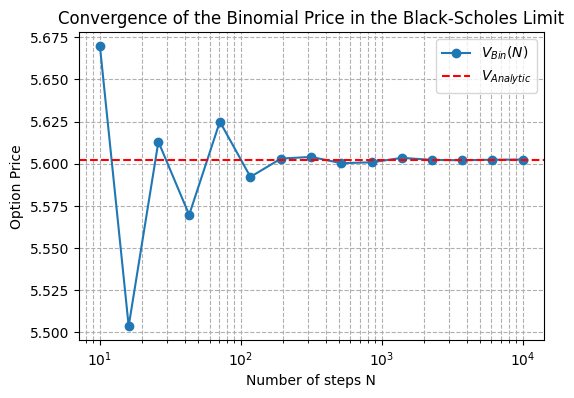

In [33]:
# Author: Jonathan Tekverk

import numpy as np
import matplotlib.pyplot as plt
from black_scholes_analytic import EuropeanOptions

def binomial_price(S, K, r, q, sigma, T, N, option_type=None):
    """
    - Computes the European option price using the Cox-Ross-Rubinstein (CRR) binomial model
    - Supports both call and put options with continuous compounding and dividend yield q
    - In the large N limit, the model converges to the Black-Scholes analytic solution

    Assumptions:
    - Underlying follows geometric Brownian motion under the risk-neutral measure
    - Constant risk-free rate, dividend yield, and annualized volatility
    - No transaction costs or arbitrage opportunities
    - European exercise only at maturity

    Inputs:
    - Current asset price S           : float
    - Strike price K                  : float
    - Risk-free interest rate r       : float
    - Dividend yield q                : float
    - Volatility sigma                : float
    - Time to maturity T              : float
    - Number of binomial steps N      : int
    - Option type option_type         : str ('call' or 'put')

    Returns:
    - Option price                    : float
    """
    # Time step per node N
    dt = T / N

    # Up and down multipliers for the underlying asset
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u

    # Risk-neutral probability for an up move, adjusted for dividend yield q
    p = (np.exp((r - q) * dt) - d) / (u - d)

    # Discount factor per time step under continuous compounding
    discount = np.exp(-r * dt)

    # Terminal asset prices at maturity vectorized with N+1 nodes
    ST = S * u ** np.arange(N, -1, -1) * d ** np.arange(0, N + 1)

    # Terminal payoffs for call or put options
    if option_type == 'call':
        values = np.maximum(ST - K, 0)
    else:
        values = np.maximum(K - ST, 0)

    # Backward induction through the tree to t=0
    for i in range(N - 1, -1, -1):
        values = discount * (p * values[:-1] + (1 - p) * values[1:])

    # Return the root node value at t=0
    return values[0]

# Example parameters used
S, K, r, q, sigma, T = 100, 110, 0.05, 0.01, 0.2, 1.0

# Define the analytic true call price for comparison
V_analytic = EuropeanOptions.call_price(S, K, r, q, sigma, T)

# Define the node spacing in N
Ns = np.unique(np.logspace(1, 4, num=15, dtype=int))

# Compute the absolute pricing error
errors = []
for N in Ns:
    V_bin = binomial_price(S, K, r, q, sigma, T, N, option_type='call')
    errors.append(abs(V_bin - V_analytic))

V_bins = [binomial_price(S, K, r, q, sigma, T, N, option_type='call') for N in Ns]

# Log–log absolute error curve (decreases monotonically like 1/N)
plt.figure()
plt.loglog(Ns, errors, marker='o')
plt.xlabel("Number of steps N")
plt.ylabel("|V_bin - V_analytic|")
plt.title("Convergence of the Binomial Model to Black-Scholes for a European Call")
plt.grid(True, which='both', ls='--')
plt.show()

# V_bin and V_analytic versus N
plt.figure(figsize=(6,4))
plt.plot(Ns, V_bins, 'o-', label=r"$V_{Bin}(N)$")
plt.axhline(V_analytic, color='r', linestyle='--', label=r"$V_{Analytic}$")
plt.xscale('log')
plt.xlabel("Number of steps N")
plt.ylabel("Option Price")
plt.title("Convergence of the Binomial Price in the Black-Scholes Limit")
plt.legend()
plt.grid(True, which='both', ls='--')
plt.show()